## Notebook Two

This time, we want to try two things!
- **Data augmentation**, we can synthesis more data to train on by rotating, and zooming in/out of our numbers, we also add elastic distortions. For other data sets you will need to do different processes.  Training data set stays 60,000, at every epoch, each image is randomly transformed.

- Creating an **Ensemble** model, instead of using a single model, we can can use several of them together and combine the scores (average, majority or other rankings.). Perhaps we want to train one model more on 9, and 4's.

In [7]:
# Imports and global parameters
# we are going to define the hyper-paramters (the model architecture, and training later)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.metrics import confusion_matrix
import copy
from tqdm import tqdm


# change this on your computer
data_dir = '/home/afinemax/data/machine_learning/mnist'

# Device
# Checks if there is a gpu, if not uses the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Load Data, and Pre-Process

This time, we augment the data by randomly rotating it +/- 10 degrees, and zooming in/out 0.8-1.4 x, and adding other distortions every time the data is drawn during an epoch 

This time, we use a batch size of 16, instead of 8. 

Mean: 0.13066047430038452
Std: 0.30810782313346863


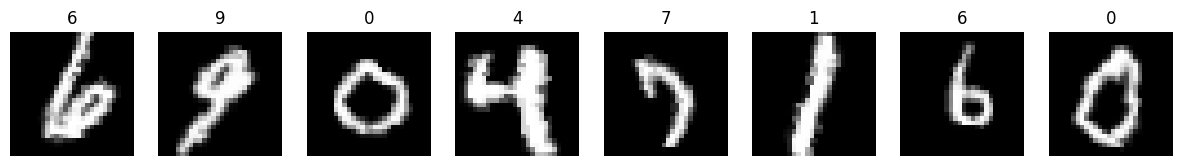

images shape: (60000, 1, 28, 28)
60000 = number of images
1 = grayscale channel
28 x 28 = image height and width


In [ ]:
# --------------------------------------------------
# 1 Compute mean and std from TRAIN set only
# --------------------------------------------------

temp_dataset = datasets.MNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

temp_loader = DataLoader(temp_dataset, batch_size=60000, shuffle=False)
images, _ = next(iter(temp_loader))

mean = images.mean()
std = images.std()

print("Mean:", mean.item())
print("Std:", std.item())


# --------------------------------------------------
# 2 Define data augmentation (TRAIN ONLY)
# --------------------------------------------------

train_transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=10,          # rotate -10° to +10°
        scale=(0.8, 1.4)     # zoom in/out
    ),
    transforms.ElasticTransform(
        alpha=30.0,         # distortion strength
        sigma=5.0           # smoothness
    ),
    transforms.ToTensor(),
    transforms.Normalize((mean.item(),), (std.item(),))
])


# --------------------------------------------------
# 3 Test transform (NO augmentation)
# --------------------------------------------------

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean.item(),), (std.item(),))
])


# --------------------------------------------------
# 4 Create datasets
# --------------------------------------------------

train_dataset = datasets.MNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.MNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=test_transform
)


# --------------------------------------------------
# 5 DataLoaders
# --------------------------------------------------

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# --------------------------------------------------
# 6 Visualize augmented samples
# --------------------------------------------------

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 8, figsize=(15, 3))

for i in range(8):
    img = images[i] * std + mean   # undo normalization
    img = img.squeeze()

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(labels[i].item())
    axes[i].axis("off")

plt.show()


print(
'images shape: (60000, 1, 28, 28)\n'
'60000 = number of images\n'
'1 = grayscale channel\n'
'28 x 28 = image height and width'
)


## Let's Define our Models

We are going to make 11 are 11 progressively different models:

CNN0 → almost fully convolutional

Gradually increasing FC depth

Slight variations in channel counts

Some wider conv, some deeper conv

We are going to keep it under/around the number of paramters (per model) as our first model in `notebook01`. 

We can plot how the different choice of hyper-parameters effects the accuracy.


| Model | Style               |
| ----- | ------------------- |
| CNN0  | Fully convolutional |
| CNN1  | Light CNN           |
| CNN2  | Original baseline   |
| CNN3  | Wider conv          |
| CNN4  | Deeper conv         |
| CNN5  | Bottleneck          |
| CNN6  | Deep FC             |
| CNN7  | Wide early          |
| CNN8  | Large kernel        |
| CNN9  | FC-heavy            |
| CNN10 | Balanced deep       |


In [8]:
class CNN0(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 12, 3, padding=1)
        self.conv2 = nn.Conv2d(12, 12, 3, padding=1)
        self.conv3 = nn.Conv2d(12, 10, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.adaptive_avg_pool2d(x, 1)
        return x.view(x.size(0), -1)
    

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        
        # 3 convolutional layers (10 filters each)
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(10, 10, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers (small)
        self.fc1 = nn.Linear(10 * 7 * 7, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 10 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(16*7*7, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 12, 3, padding=1)
        self.conv2 = nn.Conv2d(12, 12, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(12*7*7, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class CNN4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(16*7*7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


class CNN5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 1)
        self.conv2 = nn.Conv2d(16, 10, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(10*14*14, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


class CNN6(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1)
        self.conv2 = nn.Conv2d(10, 10, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(10*7*7, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class CNN7(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 10, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(10*7*7, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


class CNN8(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, padding=2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(10*14*14, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class CNN9(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(8*14*14, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    
        
class CNN10(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 12, 3, padding=1)
        self.conv3 = nn.Conv2d(12, 10, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(10*7*7, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)




## Training time!

This time, we are going to use a dynamic `lr`, as the model starts get closer to the best fit it will use a smaller `lr`, and it will use a larger one at first. 

To avoid over fitting, we are going to also have it auto-stop once it starts to plataue. 



In [9]:
epochs = 15
base_lr = 0.001
criterion = nn.CrossEntropyLoss()

In [11]:


models = {
    "CNN0": CNN0(),
    "CNN1": CNN1(),
    "CNN2": CNN2(),
    "CNN3": CNN3(),
    "CNN4": CNN4(),
    "CNN5": CNN5(),
    "CNN6": CNN6(),
    "CNN7": CNN7(),
    "CNN8": CNN8(),
    "CNN9": CNN9(),
    "CNN10": CNN10(),
}

history = {}

for name, model in models.items():

    print(f"\nTraining {name}")
    
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=base_lr)

    # Dynamic LR scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=2, factor=0.5, 
    )

    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 4
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # -------------------
        # Training
        # -------------------
        model.train()
        running_loss = 0.0
        
        for images, labels in tqdm(train_loader, leave=False):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # -------------------
        # Validation
        # -------------------
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(test_lodader)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        epoch_time = time.time() - start_time
        
        print(f"{name} | Epoch [{epoch+1}/{epochs}] "
              f"Train: {avg_train_loss:.4f} "
              f"Val: {avg_val_loss:.4f} "
              f"LR: {optimizer.param_groups[0]['lr']:.6f} "
              f"Time: {epoch_time:.2f}s")
        
        # -------------------
        # Early Stopping
        # -------------------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= early_stop_patience:
            print(f"Early stopping triggered for {name}")
            break
    
    model.load_state_dict(best_model_state)
    
    history[name] = {
        "train_loss": train_losses,
        "val_loss": val_losses
    }

print("\n All models finished training.")



Training CNN0


CNN0 | Epoch [1/15] Train: 1.0511 Val: 0.4186 LR: 0.001000 Time: 69.48s


CNN0 | Epoch [2/15] Train: 0.5499 Val: 0.2985 LR: 0.001000 Time: 60.74s


CNN0 | Epoch [3/15] Train: 0.4350 Val: 0.2152 LR: 0.001000 Time: 65.38s


CNN0 | Epoch [4/15] Train: 0.3684 Val: 0.2051 LR: 0.001000 Time: 64.25s


CNN0 | Epoch [5/15] Train: 0.3342 Val: 0.2011 LR: 0.001000 Time: 50.77s


CNN0 | Epoch [6/15] Train: 0.3051 Val: 0.1411 LR: 0.001000 Time: 56.07s


CNN0 | Epoch [7/15] Train: 0.2846 Val: 0.1394 LR: 0.001000 Time: 82.71s


CNN0 | Epoch [8/15] Train: 0.2674 Val: 0.1381 LR: 0.001000 Time: 62.63s


CNN0 | Epoch [9/15] Train: 0.2528 Val: 0.1184 LR: 0.001000 Time: 42.00s


CNN0 | Epoch [10/15] Train: 0.2449 Val: 0.1107 LR: 0.001000 Time: 54.11s


CNN0 | Epoch [11/15] Train: 0.2313 Val: 0.1145 LR: 0.001000 Time: 54.17s


CNN0 | Epoch [12/15] Train: 0.2147 Val: 0.1356 LR: 0.001000 Time: 54.33s


CNN0 | Epoch [13/15] Train: 0.2092 Val: 0.0978 LR: 0.001000 Time: 61.09s


CNN0 | Epoch [14/15] Train: 0.1978 Val: 0.1038 LR: 0.001000 Time: 59.10s


CNN0 | Epoch [15/15] Train: 0.1949 Val: 0.0899 LR: 0.001000 Time: 59.14s

Training CNN1


CNN1 | Epoch [1/15] Train: 0.2285 Val: 0.0459 LR: 0.001000 Time: 54.46s


CNN1 | Epoch [2/15] Train: 0.1038 Val: 0.0406 LR: 0.001000 Time: 50.68s


CNN1 | Epoch [3/15] Train: 0.0881 Val: 0.0341 LR: 0.001000 Time: 57.23s


CNN1 | Epoch [4/15] Train: 0.0793 Val: 0.0342 LR: 0.001000 Time: 53.71s


CNN1 | Epoch [5/15] Train: 0.0731 Val: 0.0308 LR: 0.001000 Time: 57.39s


CNN1 | Epoch [6/15] Train: 0.0711 Val: 0.0307 LR: 0.001000 Time: 56.48s


CNN1 | Epoch [7/15] Train: 0.0665 Val: 0.0297 LR: 0.001000 Time: 54.83s


CNN1 | Epoch [8/15] Train: 0.0643 Val: 0.0358 LR: 0.001000 Time: 53.78s


CNN1 | Epoch [9/15] Train: 0.0638 Val: 0.0301 LR: 0.001000 Time: 52.71s


CNN1 | Epoch [10/15] Train: 0.0622 Val: 0.0320 LR: 0.000500 Time: 58.35s


CNN1 | Epoch [11/15] Train: 0.0525 Val: 0.0268 LR: 0.000500 Time: 45.52s


CNN1 | Epoch [12/15] Train: 0.0538 Val: 0.0262 LR: 0.000500 Time: 53.91s


CNN1 | Epoch [13/15] Train: 0.0492 Val: 0.0249 LR: 0.000500 Time: 56.63s


CNN1 | Epoch [14/15] Train: 0.0503 Val: 0.0272 LR: 0.000500 Time: 52.08s


CNN1 | Epoch [15/15] Train: 0.0491 Val: 0.0243 LR: 0.000500 Time: 51.81s

Training CNN2


CNN2 | Epoch [1/15] Train: 0.3680 Val: 0.1139 LR: 0.001000 Time: 53.97s


CNN2 | Epoch [2/15] Train: 0.1462 Val: 0.0635 LR: 0.001000 Time: 57.21s


CNN2 | Epoch [3/15] Train: 0.1105 Val: 0.0538 LR: 0.001000 Time: 57.17s


CNN2 | Epoch [4/15] Train: 0.0950 Val: 0.0429 LR: 0.001000 Time: 61.18s


CNN2 | Epoch [5/15] Train: 0.0842 Val: 0.0327 LR: 0.001000 Time: 58.89s


CNN2 | Epoch [6/15] Train: 0.0771 Val: 0.0413 LR: 0.001000 Time: 58.94s


CNN2 | Epoch [7/15] Train: 0.0726 Val: 0.0358 LR: 0.001000 Time: 57.23s


CNN2 | Epoch [8/15] Train: 0.0703 Val: 0.0314 LR: 0.001000 Time: 59.16s


CNN2 | Epoch [9/15] Train: 0.0654 Val: 0.0312 LR: 0.001000 Time: 72.66s


CNN2 | Epoch [10/15] Train: 0.0645 Val: 0.0394 LR: 0.001000 Time: 77.48s


CNN2 | Epoch [11/15] Train: 0.0622 Val: 0.0308 LR: 0.001000 Time: 61.87s


CNN2 | Epoch [12/15] Train: 0.0611 Val: 0.0260 LR: 0.001000 Time: 72.80s


CNN2 | Epoch [13/15] Train: 0.0595 Val: 0.0272 LR: 0.001000 Time: 75.48s


CNN2 | Epoch [14/15] Train: 0.0587 Val: 0.0413 LR: 0.001000 Time: 66.67s


CNN2 | Epoch [15/15] Train: 0.0575 Val: 0.0366 LR: 0.000500 Time: 77.29s

Training CNN3


CNN3 | Epoch [1/15] Train: 0.2564 Val: 0.0647 LR: 0.001000 Time: 70.08s


CNN3 | Epoch [2/15] Train: 0.1187 Val: 0.0390 LR: 0.001000 Time: 68.99s


CNN3 | Epoch [3/15] Train: 0.0964 Val: 0.0347 LR: 0.001000 Time: 72.36s


CNN3 | Epoch [4/15] Train: 0.0864 Val: 0.0327 LR: 0.001000 Time: 66.81s


CNN3 | Epoch [5/15] Train: 0.0801 Val: 0.0372 LR: 0.001000 Time: 78.34s


CNN3 | Epoch [6/15] Train: 0.0726 Val: 0.0315 LR: 0.001000 Time: 69.34s


CNN3 | Epoch [7/15] Train: 0.0683 Val: 0.0315 LR: 0.001000 Time: 75.45s


CNN3 | Epoch [8/15] Train: 0.0665 Val: 0.0285 LR: 0.001000 Time: 65.58s


CNN3 | Epoch [9/15] Train: 0.0621 Val: 0.0250 LR: 0.001000 Time: 68.45s


CNN3 | Epoch [10/15] Train: 0.0623 Val: 0.0344 LR: 0.001000 Time: 80.78s


CNN3 | Epoch [11/15] Train: 0.0587 Val: 0.0297 LR: 0.001000 Time: 67.33s


CNN3 | Epoch [12/15] Train: 0.0546 Val: 0.0297 LR: 0.000500 Time: 71.41s


CNN3 | Epoch [13/15] Train: 0.0503 Val: 0.0235 LR: 0.000500 Time: 57.91s


CNN3 | Epoch [14/15] Train: 0.0482 Val: 0.0216 LR: 0.000500 Time: 74.34s


CNN3 | Epoch [15/15] Train: 0.0464 Val: 0.0231 LR: 0.000500 Time: 79.33s

Training CNN4


CNN4 | Epoch [1/15] Train: 0.2202 Val: 0.0578 LR: 0.001000 Time: 59.06s


CNN4 | Epoch [2/15] Train: 0.1018 Val: 0.0343 LR: 0.001000 Time: 80.17s


CNN4 | Epoch [3/15] Train: 0.0835 Val: 0.0314 LR: 0.001000 Time: 82.66s


CNN4 | Epoch [4/15] Train: 0.0752 Val: 0.0313 LR: 0.001000 Time: 72.30s


CNN4 | Epoch [5/15] Train: 0.0666 Val: 0.0483 LR: 0.001000 Time: 66.13s


CNN4 | Epoch [6/15] Train: 0.0635 Val: 0.0322 LR: 0.001000 Time: 69.06s


CNN4 | Epoch [7/15] Train: 0.0610 Val: 0.0272 LR: 0.001000 Time: 59.20s


CNN4 | Epoch [8/15] Train: 0.0593 Val: 0.0262 LR: 0.001000 Time: 71.63s


CNN4 | Epoch [9/15] Train: 0.0567 Val: 0.0222 LR: 0.001000 Time: 67.74s


CNN4 | Epoch [10/15] Train: 0.0540 Val: 0.0252 LR: 0.001000 Time: 65.29s


CNN4 | Epoch [11/15] Train: 0.0565 Val: 0.0231 LR: 0.001000 Time: 77.62s


CNN4 | Epoch [12/15] Train: 0.0546 Val: 0.0285 LR: 0.000500 Time: 81.27s


CNN4 | Epoch [13/15] Train: 0.0434 Val: 0.0195 LR: 0.000500 Time: 63.27s


CNN4 | Epoch [14/15] Train: 0.0451 Val: 0.0204 LR: 0.000500 Time: 80.67s


CNN4 | Epoch [15/15] Train: 0.0429 Val: 0.0211 LR: 0.000500 Time: 63.98s

Training CNN5


CNN5 | Epoch [1/15] Train: 0.2771 Val: 0.0824 LR: 0.001000 Time: 76.84s


CNN5 | Epoch [2/15] Train: 0.1541 Val: 0.0631 LR: 0.001000 Time: 75.21s


CNN5 | Epoch [3/15] Train: 0.1317 Val: 0.0589 LR: 0.001000 Time: 68.83s


CNN5 | Epoch [4/15] Train: 0.1252 Val: 0.0533 LR: 0.001000 Time: 66.64s


CNN5 | Epoch [5/15] Train: 0.1180 Val: 0.0489 LR: 0.001000 Time: 56.28s


CNN5 | Epoch [6/15] Train: 0.1123 Val: 0.0480 LR: 0.001000 Time: 74.18s


CNN5 | Epoch [7/15] Train: 0.1075 Val: 0.0508 LR: 0.001000 Time: 68.93s


CNN5 | Epoch [8/15] Train: 0.1052 Val: 0.0452 LR: 0.001000 Time: 70.94s


CNN5 | Epoch [9/15] Train: 0.1015 Val: 0.0408 LR: 0.001000 Time: 44.27s


CNN5 | Epoch [10/15] Train: 0.0989 Val: 0.0420 LR: 0.001000 Time: 71.51s


CNN5 | Epoch [11/15] Train: 0.0994 Val: 0.0419 LR: 0.001000 Time: 65.77s


CNN5 | Epoch [12/15] Train: 0.0964 Val: 0.0413 LR: 0.000500 Time: 72.10s


CNN5 | Epoch [13/15] Train: 0.0895 Val: 0.0400 LR: 0.000500 Time: 62.86s


CNN5 | Epoch [14/15] Train: 0.0861 Val: 0.0386 LR: 0.000500 Time: 79.37s


CNN5 | Epoch [15/15] Train: 0.0844 Val: 0.0393 LR: 0.000500 Time: 55.28s

Training CNN6


CNN6 | Epoch [1/15] Train: 0.2538 Val: 0.0573 LR: 0.001000 Time: 72.01s


CNN6 | Epoch [2/15] Train: 0.1074 Val: 0.0514 LR: 0.001000 Time: 72.38s


CNN6 | Epoch [3/15] Train: 0.0889 Val: 0.0377 LR: 0.001000 Time: 66.67s


CNN6 | Epoch [4/15] Train: 0.0781 Val: 0.0309 LR: 0.001000 Time: 76.98s


CNN6 | Epoch [5/15] Train: 0.0709 Val: 0.0316 LR: 0.001000 Time: 60.73s


CNN6 | Epoch [6/15] Train: 0.0634 Val: 0.0330 LR: 0.001000 Time: 78.19s


CNN6 | Epoch [7/15] Train: 0.0610 Val: 0.0336 LR: 0.000500 Time: 56.71s


CNN6 | Epoch [8/15] Train: 0.0497 Val: 0.0217 LR: 0.000500 Time: 65.73s


CNN6 | Epoch [9/15] Train: 0.0473 Val: 0.0232 LR: 0.000500 Time: 81.25s


CNN6 | Epoch [10/15] Train: 0.0441 Val: 0.0221 LR: 0.000500 Time: 73.10s


CNN6 | Epoch [11/15] Train: 0.0439 Val: 0.0266 LR: 0.000250 Time: 72.54s


CNN6 | Epoch [12/15] Train: 0.0379 Val: 0.0199 LR: 0.000250 Time: 84.01s


CNN6 | Epoch [13/15] Train: 0.0362 Val: 0.0201 LR: 0.000250 Time: 79.62s


CNN6 | Epoch [14/15] Train: 0.0373 Val: 0.0199 LR: 0.000250 Time: 63.63s


CNN6 | Epoch [15/15] Train: 0.0358 Val: 0.0196 LR: 0.000250 Time: 79.18s

Training CNN7


CNN7 | Epoch [1/15] Train: 0.2394 Val: 0.0554 LR: 0.001000 Time: 61.14s


CNN7 | Epoch [2/15] Train: 0.1170 Val: 0.0463 LR: 0.001000 Time: 50.65s


CNN7 | Epoch [3/15] Train: 0.0995 Val: 0.0418 LR: 0.001000 Time: 51.36s


CNN7 | Epoch [4/15] Train: 0.0886 Val: 0.0389 LR: 0.001000 Time: 56.99s


CNN7 | Epoch [5/15] Train: 0.0861 Val: 0.0375 LR: 0.001000 Time: 69.27s


CNN7 | Epoch [6/15] Train: 0.0793 Val: 0.0341 LR: 0.001000 Time: 69.50s


CNN7 | Epoch [7/15] Train: 0.0735 Val: 0.0419 LR: 0.001000 Time: 81.48s


CNN7 | Epoch [8/15] Train: 0.0710 Val: 0.0376 LR: 0.001000 Time: 55.80s


CNN7 | Epoch [9/15] Train: 0.0706 Val: 0.0336 LR: 0.001000 Time: 77.87s


CNN7 | Epoch [10/15] Train: 0.0676 Val: 0.0316 LR: 0.001000 Time: 56.76s


CNN7 | Epoch [11/15] Train: 0.0655 Val: 0.0340 LR: 0.001000 Time: 55.98s


CNN7 | Epoch [12/15] Train: 0.0668 Val: 0.0315 LR: 0.001000 Time: 50.59s


CNN7 | Epoch [13/15] Train: 0.0645 Val: 0.0346 LR: 0.001000 Time: 53.30s


CNN7 | Epoch [14/15] Train: 0.0635 Val: 0.0329 LR: 0.001000 Time: 55.67s


CNN7 | Epoch [15/15] Train: 0.0630 Val: 0.0312 LR: 0.001000 Time: 55.56s

Training CNN8


CNN8 | Epoch [1/15] Train: 0.2799 Val: 0.0777 LR: 0.001000 Time: 55.59s


CNN8 | Epoch [2/15] Train: 0.1458 Val: 0.0640 LR: 0.001000 Time: 55.74s


CNN8 | Epoch [3/15] Train: 0.1229 Val: 0.0494 LR: 0.001000 Time: 62.48s


CNN8 | Epoch [4/15] Train: 0.1085 Val: 0.0616 LR: 0.001000 Time: 64.15s


CNN8 | Epoch [5/15] Train: 0.1007 Val: 0.0699 LR: 0.001000 Time: 64.94s


CNN8 | Epoch [6/15] Train: 0.0951 Val: 0.0438 LR: 0.001000 Time: 64.99s


CNN8 | Epoch [7/15] Train: 0.0920 Val: 0.0354 LR: 0.001000 Time: 65.67s


CNN8 | Epoch [8/15] Train: 0.0873 Val: 0.0324 LR: 0.001000 Time: 64.84s


CNN8 | Epoch [9/15] Train: 0.0826 Val: 0.0406 LR: 0.001000 Time: 60.98s


CNN8 | Epoch [10/15] Train: 0.0818 Val: 0.0347 LR: 0.001000 Time: 58.27s


CNN8 | Epoch [11/15] Train: 0.0790 Val: 0.0357 LR: 0.000500 Time: 64.43s


CNN8 | Epoch [12/15] Train: 0.0679 Val: 0.0308 LR: 0.000500 Time: 62.78s


CNN8 | Epoch [13/15] Train: 0.0634 Val: 0.0287 LR: 0.000500 Time: 63.88s


CNN8 | Epoch [14/15] Train: 0.0600 Val: 0.0286 LR: 0.000500 Time: 64.98s


CNN8 | Epoch [15/15] Train: 0.0621 Val: 0.0299 LR: 0.000500 Time: 56.15s

Training CNN9


CNN9 | Epoch [1/15] Train: 0.2918 Val: 0.0852 LR: 0.001000 Time: 62.41s


CNN9 | Epoch [2/15] Train: 0.1372 Val: 0.0601 LR: 0.001000 Time: 62.93s


CNN9 | Epoch [3/15] Train: 0.1129 Val: 0.0504 LR: 0.001000 Time: 63.94s


CNN9 | Epoch [4/15] Train: 0.1010 Val: 0.0483 LR: 0.001000 Time: 59.46s


CNN9 | Epoch [5/15] Train: 0.0907 Val: 0.0412 LR: 0.001000 Time: 63.07s


CNN9 | Epoch [6/15] Train: 0.0832 Val: 0.0470 LR: 0.001000 Time: 63.57s


CNN9 | Epoch [7/15] Train: 0.0774 Val: 0.0438 LR: 0.001000 Time: 64.40s


CNN9 | Epoch [8/15] Train: 0.0757 Val: 0.0364 LR: 0.001000 Time: 64.75s


CNN9 | Epoch [9/15] Train: 0.0715 Val: 0.0393 LR: 0.001000 Time: 63.99s


CNN9 | Epoch [10/15] Train: 0.0658 Val: 0.0381 LR: 0.001000 Time: 64.74s


CNN9 | Epoch [11/15] Train: 0.0655 Val: 0.0324 LR: 0.001000 Time: 63.90s


CNN9 | Epoch [12/15] Train: 0.0641 Val: 0.0400 LR: 0.001000 Time: 63.23s


CNN9 | Epoch [13/15] Train: 0.0631 Val: 0.0341 LR: 0.001000 Time: 56.70s


CNN9 | Epoch [14/15] Train: 0.0617 Val: 0.0382 LR: 0.000500 Time: 41.60s


CNN9 | Epoch [15/15] Train: 0.0523 Val: 0.0291 LR: 0.000500 Time: 43.20s

Training CNN10


CNN10 | Epoch [1/15] Train: 0.2657 Val: 0.0574 LR: 0.001000 Time: 61.00s


CNN10 | Epoch [2/15] Train: 0.1138 Val: 0.0421 LR: 0.001000 Time: 56.15s


CNN10 | Epoch [3/15] Train: 0.0892 Val: 0.0388 LR: 0.001000 Time: 60.35s


CNN10 | Epoch [4/15] Train: 0.0798 Val: 0.0377 LR: 0.001000 Time: 60.87s


CNN10 | Epoch [5/15] Train: 0.0746 Val: 0.0319 LR: 0.001000 Time: 60.83s


CNN10 | Epoch [6/15] Train: 0.0679 Val: 0.0327 LR: 0.001000 Time: 60.26s


CNN10 | Epoch [7/15] Train: 0.0650 Val: 0.0337 LR: 0.001000 Time: 60.47s


CNN10 | Epoch [8/15] Train: 0.0625 Val: 0.0322 LR: 0.000500 Time: 57.33s


CNN10 | Epoch [9/15] Train: 0.0523 Val: 0.0284 LR: 0.000500 Time: 53.30s


CNN10 | Epoch [10/15] Train: 0.0514 Val: 0.0337 LR: 0.000500 Time: 54.50s


CNN10 | Epoch [11/15] Train: 0.0509 Val: 0.0296 LR: 0.000500 Time: 61.14s


CNN10 | Epoch [12/15] Train: 0.0478 Val: 0.0303 LR: 0.000250 Time: 60.34s


CNN10 | Epoch [13/15] Train: 0.0440 Val: 0.0284 LR: 0.000250 Time: 60.96s
Early stopping triggered for CNN10

 All models finished training.


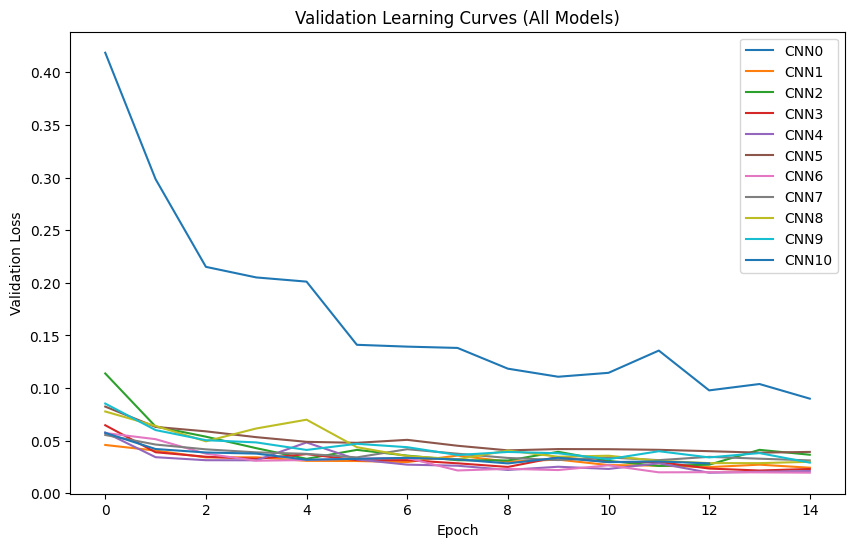

In [12]:
plt.figure(figsize=(10,6))

for name in history:
    plt.plot(history[name]["val_loss"], label=name)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Learning Curves (All Models)")
plt.legend()
plt.show()


In [13]:
import os
import torch
import pandas as pd

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

for name, model in models.items():
    
    # -------------------------
    # Save model weights
    # -------------------------
    model_path = os.path.join(save_dir, f"{name}_best.pt")
    torch.save(model.state_dict(), model_path)
    
    # -------------------------
    # Save training history
    # -------------------------
    history_path = os.path.join(save_dir, f"{name}_history.pt")
    torch.save(history[name], history_path)
    
    # Optional: save as CSV for easy plotting
    df = pd.DataFrame({
        "epoch": range(1, len(history[name]["train_loss"]) + 1),
        "train_loss": history[name]["train_loss"],
        "val_loss": history[name]["val_loss"]
    })
    
    csv_path = os.path.join(save_dir, f"{name}_history.csv")
    df.to_csv(csv_path, index=False)

print("✅ All trained models and histories saved.")


✅ All trained models and histories saved.


In [14]:
import torch

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total


results = {}

for name, model in models.items():
    acc = evaluate_accuracy(model, test_loader, device)
    results[name] = acc
    print(f"{name}: {acc:.4f} ({acc*100:.2f}%)")

# -------------------------
# Rank models
# -------------------------
print("\n--- Model Ranking ---")
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

for i, (name, acc) in enumerate(sorted_results, 1):
    print(f"{i}. {name} - {acc:.4f}")

best_model_name = sorted_results[0][0]
print(f"\n🏆 Best Model: {best_model_name}")


CNN0: 0.9706 (97.06%)
CNN1: 0.9920 (99.20%)
CNN2: 0.9919 (99.19%)
CNN3: 0.9925 (99.25%)
CNN4: 0.9934 (99.34%)
CNN5: 0.9877 (98.77%)
CNN6: 0.9932 (99.32%)
CNN7: 0.9908 (99.08%)
CNN8: 0.9910 (99.10%)
CNN9: 0.9908 (99.08%)
CNN10: 0.9900 (99.00%)

--- Model Ranking ---
1. CNN4 - 0.9934
2. CNN6 - 0.9932
3. CNN3 - 0.9925
4. CNN1 - 0.9920
5. CNN2 - 0.9919
6. CNN8 - 0.9910
7. CNN7 - 0.9908
8. CNN9 - 0.9908
9. CNN10 - 0.9900
10. CNN5 - 0.9877
11. CNN0 - 0.9706

🏆 Best Model: CNN4


In [15]:
import torch
import numpy as np
import pandas as pd

def per_class_accuracy(model, loader, device, num_classes=10):
    model.eval()
    
    correct = np.zeros(num_classes)
    total = np.zeros(num_classes)
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            for i in range(len(labels)):
                label = labels[i].item()
                total[label] += 1
                if preds[i].item() == label:
                    correct[label] += 1
    
    return correct / total


# Store results
per_digit_results = {}

for name, model in models.items():
    accs = per_class_accuracy(model, test_loader, device)
    per_digit_results[name] = accs

# Convert to DataFrame for readability
df_per_digit = pd.DataFrame(per_digit_results)
df_per_digit.index = [f"Digit {i}" for i in range(10)]

df_per_digit


,CNN0,CNN1,CNN2,CNN3,CNN4,CNN5,CNN6,CNN7,CNN8,CNN9,CNN10
Digit 0,0.972449,0.996939,0.993878,0.994898,0.996939,0.992857,1.000000,0.996939,0.995918,0.995918,0.998980
Digit 1,0.987665,0.998238,0.991189,0.999119,0.997357,0.994714,0.998238,0.998238,0.992952,0.992952,0.995595
Digit 2,0.959302,0.991279,0.996124,0.995155,0.993217,0.989341,0.994186,0.992248,0.993217,0.991279,0.990310
Digit 3,0.982178,0.991089,0.989109,0.994059,0.996040,0.989109,0.996040,0.988119,0.992079,0.991089,0.994059
Digit 4,0.963340,0.989817,0.995927,0.990835,0.994908,0.986762,0.991853,0.994908,0.994908,0.986762,0.984725
Digit 5,0.965247,0.994395,0.994395,0.991031,0.995516,0.991031,0.985426,0.991031,0.992152,0.994395,0.987668
Digit 6,0.970772,0.989562,0.986430,0.983299,0.988518,0.988518,0.990605,0.987474,0.984342,0.985386,0.988518
Digit 7,0.962062,0.994163,0.996109,0.993191,0.993191,0.984436,0.995136,0.993191,0.993191,0.993191,0.988327
Digit 8,0.971253,0.986653,0.992813,0.991786,0.990760,0.985626,0.992813,0.989733,0.990760,0.995893,0.992813
Digit 9,0.969277,0.987116,0.983152,0.990089,0.987116,0.974232,0.986125,0.975223,0.980178,0.981169,0.978196


In [17]:
# Get best model for each digit
best_model_per_digit = df_per_digit.idxmax(axis=1)

# Also get the corresponding accuracy
best_accuracy_per_digit = df_per_digit.max(axis=1)

# Combine into clean table
best_table = pd.DataFrame({
    "Best Model": best_model_per_digit,
    "Accuracy": best_accuracy_per_digit
})

best_table


,Best Model,Accuracy
Digit 0,CNN6,1.000000
Digit 1,CNN3,0.999119
Digit 2,CNN2,0.996124
Digit 3,CNN4,0.996040
Digit 4,CNN2,0.995927
Digit 5,CNN4,0.995516
Digit 6,CNN6,0.990605
Digit 7,CNN2,0.996109
Digit 8,CNN9,0.995893
Digit 9,CNN3,0.990089


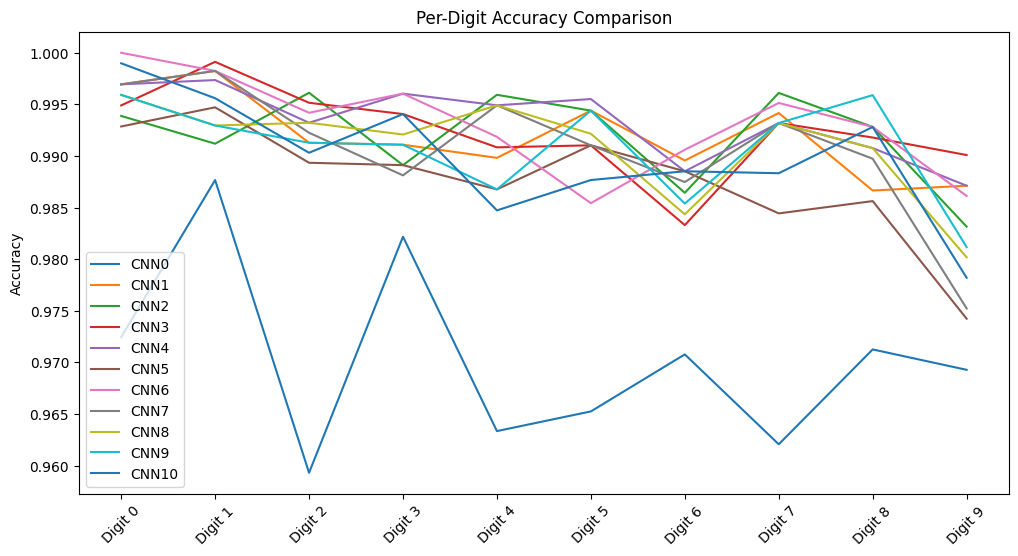

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for name in df_per_digit.columns:
    plt.plot(df_per_digit.index, df_per_digit[name], label=name)

plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Per-Digit Accuracy Comparison")
plt.legend()
plt.show()


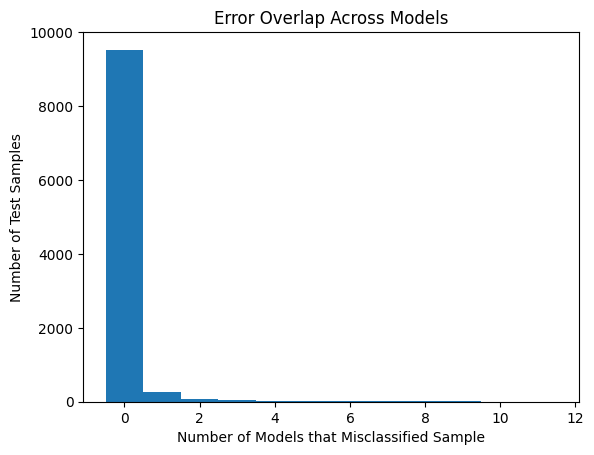

11 models wrong = 6
10 models wrong = 4
9 models wrong = 11
8 models wrong = 12
7 models wrong = 15
6 models wrong = 13
5 models wrong = 10
4 models wrong = 28
3 models wrong = 35
2 models wrong = 70
1 models wrong = 270
0 models wrong = 9526


In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def error_overlap(models, loader, device):
    model_list = list(models.values())
    num_models = len(model_list)
    
    for model in model_list:
        model.eval()
    
    error_counts = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            batch_size = labels.size(0)
            batch_errors = torch.zeros(batch_size).to(device)
            
            for model in model_list:
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                batch_errors += (preds != labels).float()
            
            error_counts.extend(batch_errors.cpu().numpy())
    
    return np.array(error_counts)


# Compute error overlap
error_counts = error_overlap(models, test_loader, device)

# Plot histogram
plt.figure()
plt.hist(error_counts, bins=np.arange(0, len(models)+2) - 0.5)
plt.xlabel("Number of Models that Misclassified Sample")
plt.ylabel("Number of Test Samples")
plt.title("Error Overlap Across Models")
#plt.xlim(1, 10)
plt.show()

# Convert to integer (since it's float from accumulation)
error_counts = error_counts.astype(int)

num_models = len(models)

# Count occurrences for each k
for k in range(num_models, -1, -1):
    count = np.sum(error_counts == k)
    print(f"{k} models wrong = {count}")

